# yolov5

## Clone & install

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt comet_ml  # install

import torch
import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v7.0-226-gdd9e338 Python-3.10.12 torch-2.0.1+cu118 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.5/107.7 GB disk)


In [ ]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="xxx")
# project = rf.workspace("capstone-objectdetection-2").project("furniture-ready")
# dataset = project.version(1).download("yolov5")


!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="xxx")
project = rf.workspace("fa23ai02-object-detection").project("iot-kit-augmented")
dataset = project.version(1).download("yolov5") # 874 images

## Train

In [ ]:
!python train.py --img 640 --freeze 10 --epochs 100\
          --data /content/yolov5/Furniture-Ready-1/data.yaml\
          --weights /content/drive/MyDrive/AI_Engineer/yolov5_train/v5x66/weights/last.pt\
          --project /content/drive/MyDrive/AI_Engineer/yolov5_train\
          --name v5x6\
          --batch-size -1\
          --hyp /content/yolov5/data/hyps/hyp.scratch-high.yaml\
	        --save-period 5\
          --patience 10\
          --resume /content/drive/MyDrive/AI_Engineer/yolov5_train/v5x66/weights/epoch80.pt

In [ ]:
IOT_PROJECT = '/content/drive/MyDrive/yolov5_train/iot'
train_version = f'v5x6'                                                           # v5x6, v5x64, ... to resume / continue
IOT_MODEL = f'{IOT_PROJECT}/{train_version}/weights/best.pt'
IOT_DATA_864 = '/content/yolov5/IoT-Kit-2/data.yaml'


!python val.py --weights {IOT_MODEL}\
               --data {IOT_DATA_864} --img 640\
               --task test\
               --project {IOT_PROJECT}\
               --name {train_version}\
               --save-txt\
               --save-conf

In [12]:
!mv /content/yolov5/IoT-Kit-Augmented-1/test /content/yolov5/

## Process image(draw bounding box & counts), then save.


In [72]:
import cv2, os, yaml
from PIL import Image
def _process_img(image_file:str, label_file:str ,max_img_size=(640, 640)):
   # '''Read image - Draw bbox - Save image'''

    # get class mapping id-name
    with open('/content/yolov5/IoT-Kit-Augmented-1/data.yaml', 'r') as f:
        data_info = yaml.load(f, Loader=yaml.loader.SafeLoader)
        classes = data_info['names']

    # Get object(bbox) info from label file
    with open(label_file, 'r') as f:
        label_content = f.readlines()
    # label_content_split = label_content.split()
    # print(label_content)
    number_of_objects = int(len(label_content))
    print('no of objects: ', number_of_objects)
    object_list = [bbox.split() for bbox in label_content]

    # get counts for each class, turn into string
    obj_counts = {}
    for obj in object_list:
      obj_id = int(obj[0])
      obj_name = classes[obj_id]
      obj_counts.update({obj_name: obj_counts.get(obj_name, 0)+1})
    obj_counts_str = ''
    for (classname, count) in obj_counts.items():
      obj_counts_str += f'{classname}: {count}\n'
    # print(obj_counts_str)

    # Read image
    img =cv2.imread(image_file)
    w,h = img.shape[:2]

    for _current_id in range(number_of_objects):   # plot all bboxes
      cur_object = object_list[_current_id]

      object_class_id = int(cur_object[0])    # object: [class, x, y, w, h]
      object_class_mapping = data_info['names']
      object_class_name = object_class_mapping[object_class_id]

      conf_score = round(float(cur_object[-1].rstrip('\n')), 3)

      center_x_ratio, center_y_ratio, w_ratio, h_ratio = [float(i) for i in cur_object[1:5]]
      x1, x2 = [int(w*x_i) for x_i in (center_x_ratio-w_ratio/2, center_x_ratio+w_ratio/2)]
      y1, y2 = [int(h*y_i) for y_i in (center_y_ratio-h_ratio/2, center_y_ratio+h_ratio/2)]

      # Add bounding box & labelled_class to image
      img = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
      img = cv2.putText(img, f"{object_class_name}, {conf_score}",(x1, y1+8), # top left
                        cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3,
                        color=(0, 0, 200), thickness=1)

    # Add Object counts to image

    x0, y0, dy = 10, 10, 20
    for i, line in enumerate(obj_counts_str.split('\n')):
        y = y0 + i*dy
        cv2.putText(img, line, (x0, y),
                      cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3,
                      color=(0, 0, 200), thickness=1)

    # convert cv2 to PIL image type
    tmp_color_coverted = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(tmp_color_coverted)

    # resize PIL image
    w, h = pil_image.size
    ratio = min(max_img_size[0]/w, max_img_size[1]/h)
    newsize = (int(w*ratio), int(h*ratio))
    resized_image = pil_image.resize(newsize, Image.LANCZOS)
    return resized_image


def process_img_folder(image_folder, label_folder, new_image_folder:str):
  all_images = os.listdir(image_folder)
  for image_name in all_images:
    label_name = image_name[:-4] +'.txt'

    label_file = os.path.join(label_folder, label_name)
    image_file = os.path.join(image_folder, image_name)
    image_new_file = os.path.join(new_image_folder, image_name)

    processed_image = _process_img(image_file, label_file)
    processed_image.save(image_new_file)
    print('img ', image_name, ' done.')

In [73]:
!mkdir '/content/drive/MyDrive/AI_Engineer/yolov5_train/iot/v5x62/img_with_preds'
process_img_folder(image_folder = '/content/yolov5/test/images',
                   label_folder = '/content/drive/MyDrive/AI_Engineer/yolov5_train/iot/v5x62/labels',
                   new_image_folder = '/content/drive/MyDrive/AI_Engineer/yolov5_train/iot/v5x62/img_with_preds')

no of objects:  23
img  IMG_20230919_151000_jpg.rf.17b7b9c2b36b3c08fa8fa46e8eb02f85.jpg  done.
no of objects:  82
img  IMG_20230919_152802_jpg.rf.154b3cae3b16d2eb4225f4e46aab5717.jpg  done.
no of objects:  51
img  1695203528976_jpg.rf.7594721517e67be9153be0fb6425d53d.jpg  done.
no of objects:  15
img  IMG_20230919_150930_jpg.rf.66f2ce75e0b214a2eb7aa44ad7ab5a35.jpg  done.
no of objects:  43
img  IMG_20230919_153111_jpg.rf.a6d270b984efc69ec9071a7cbef761af.jpg  done.
no of objects:  300
img  IMG_20230919_152511_jpg.rf.5344725a978a07ab68e2e9a9d7d932b7.jpg  done.
no of objects:  300
img  IMG_20230919_152515_jpg.rf.f0e61a9cd43c2d054c01c4018125d0d2.jpg  done.


Demo on one image

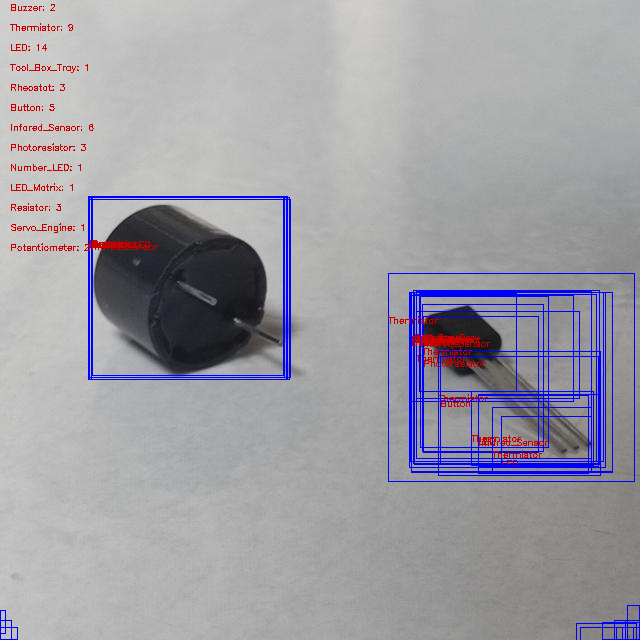

In [61]:
from PIL import Image               # to load images
from IPython.display import display # to display images

plotted_img = process_img(image_file='/content/yolov5/test/images/1695203528976_jpg.rf.7594721517e67be9153be0fb6425d53d.jpg',
                          label_file='/content/drive/MyDrive/AI_Engineer/yolov5_train/iot/v5x62/labels/1695203528976_jpg.rf.7594721517e67be9153be0fb6425d53d.txt')
display(plotted_img)